# Generating Noise Images

I watched [this video](https://youtu.be/lctXaT9pxA0) by Sebastian Lague where he procedurally generated planets and moons in Unity. In this video he just briefly showed some trippy art made with noise generation algorithms, which inspired me to make this. In this notebook I've made some cool art using noise sampling algorithms

In [53]:
from ipywidgets import interact
import numpy as np
from matplotlib import pyplot as plt
from skimage import transform as skt
from PIL import Image
plt.rcParams['figure.figsize'] = [12, 9]
plt.rcParams['image.cmap'] = 'gray'

Let's start with basic white noise. Just generate an image where each pixel value is generated randomly.

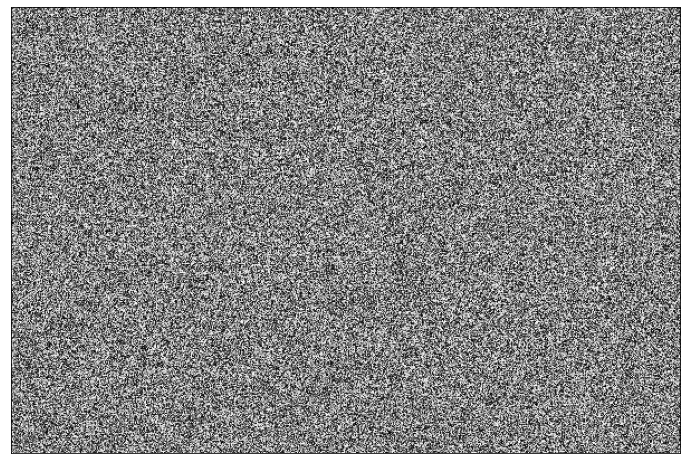

In [54]:
# Create random noise image
rng = np.random.default_rng()
white_noise = rng.random((400, 600))

# Show image
plt.imshow(white_noise)
plt.xticks([])
plt.yticks([]);

Seems kind of boring, like TV static. How do we make this more... organic?

What if we sample the image, and then scaled it up, interpolating between the sampled points to create a smooth boundary? I think this is called value noise.

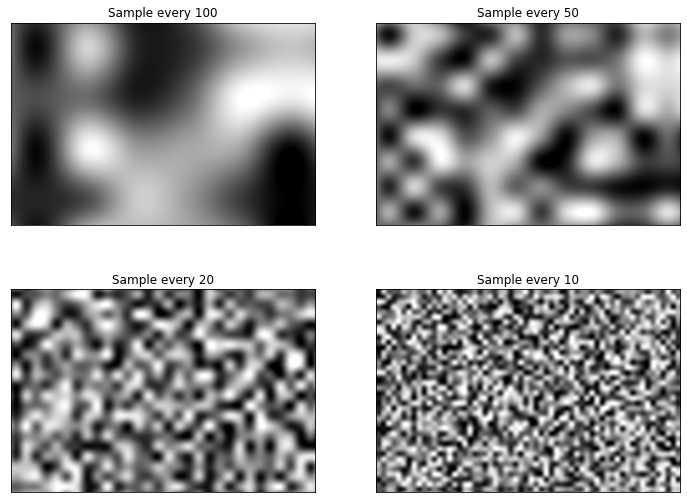

In [55]:
def sample(r):
    """
    Sample points within the buffer.
    Then rescale while cubically 
    interpolating between points
    This can be done using scikit-image's
    rescale function. We set the order to
    3 to indicate cubic interpolation
    """
    ips = np.arange(0, 600, r)
    jps = np.arange(0, 400, r)
    j,i = np.meshgrid(ips,jps)
    return skt.rescale(white_noise[i,j], r, order=3)

# Get some samples
sample_0 = sample(100)
sample_1 = sample(50)
sample_2 = sample(20)
sample_3 = sample(10)

# Show image
plt.figure()
plt.subplot(2,2,1)
plt.imshow(sample_0)
plt.title('Sample every 100')
plt.xticks([])
plt.yticks([])
plt.subplot(2,2,2)
plt.imshow(sample_1)
plt.title('Sample every 50')
plt.xticks([])
plt.yticks([])
plt.subplot(2,2,3)
plt.imshow(sample_2)
plt.title('Sample every 20')
plt.xticks([])
plt.yticks([])
plt.subplot(2,2,4)
plt.imshow(sample_3)
plt.title('Sample every 10')
plt.xticks([])
plt.yticks([]);

As you can see, we can sample the noise buffer at any resolution to get more and more detail in the noise, but it still looks more structured.

What's more: We can sum these individual noise points together to create a more complex pattern, called fractal noise.

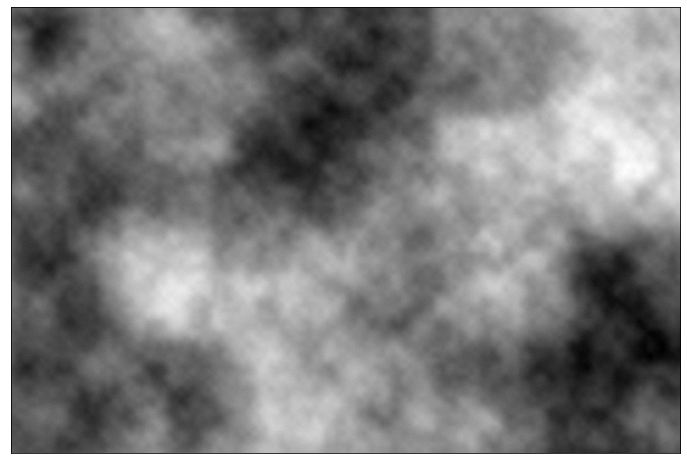

In [56]:
# Parameters
# Scales are all common factors of the image dimensions
scales = [ 100, 50, 20, 10, 5, 1 ]

# Get sampled images and factors
sampled_images = np.array([ sample(scale) for scale in scales ])
factors = np.array([ [[0.5**i]] for i in range(len(scales)) ])

# Noise is a normalized weighted sum of these samples
fractal_noise = (factors*sampled_images).sum(axis=0)
fractal_noise /= factors.sum(axis=0)

# Show image
plt.figure()
plt.imshow(fractal_noise)
plt.xticks([])
plt.yticks([]);

Now that's pretty nifty! However, Sebastian Lague did something even more awesome. He mentioned offsetting each point using more noise, which created the trippy art that I wanted to recreate. Let's try doing that. I'll generate another noise buffer, and then scale it up and convert it to integers to create a pixel offset buffer. Then I'll create a new image by indexing pixels from the old image using the offset buffer.

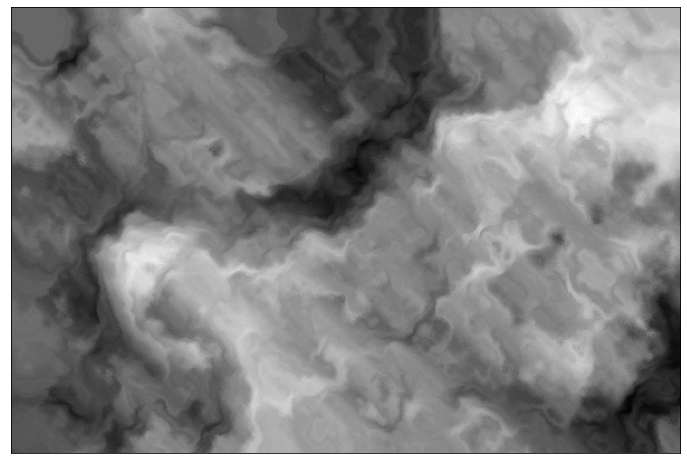

In [57]:
def make_noise():
    # Scales are all common factors of the image dimensions
    scales = [ 100, 50, 20, 10, 5, 1 ]

    # Get sampled images and factors
    sampled_images = np.array([ sample(scale) for scale in scales ])
    factors = np.array([ [[0.5**i]] for i in range(len(scales)) ])

    # Noise is a normalized weighted sum of these samples
    fractal_noise = (factors*sampled_images).sum(axis=0)
    fractal_noise /= factors.sum(axis=0)
    return fractal_noise

# Create noise and map to an offset factor
offset = 90
offset_noise = ( make_noise() * offset * 2 - offset ).astype( np.int8 )

# Offset the noise buffer using te offsets generated
j_index, i_index = np.meshgrid(np.arange(600), np.arange(400))
i_offset = np.clip(offset_noise + i_index, 0, 399)
j_offset = np.clip(offset_noise + j_index, 0, 599)

# Update offset_noise
offsetted_noise = fractal_noise[i_offset, j_offset]
        
# Normalize
offsetted_min = np.min(offsetted_noise)
offsetted_max = np.max(offsetted_noise)
offsetted_noise = (offsetted_noise - offsetted_min) / (offsetted_max - offsetted_min)
     
# Show image
plt.figure()
plt.imshow(offsetted_noise)
plt.xticks([])
plt.yticks([]);

Now THAT's what I'm looking for! Let's add some color to this! First, lemme generate some colors. What I'm doing here is generating gradients between consecutive pairs of colors and then stiching all of the gradients together to create one long multi-gradient colormap

Colorspace: 1024


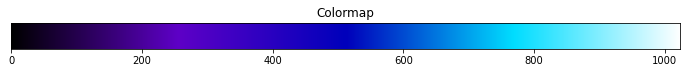

In [58]:
# Gradient colors
gradient = np.array([
    0x000000,
    0x5e00c7,
    0x0000bb,
    0x00ddff,
    0xffffff
])

# Create colormap
channel_shifts = np.array([[16, 8, 0]])
channel_mask = 0xff
gradient_channels = (gradient.reshape(-1,1) >> channel_shifts) & channel_mask
gradient_channels = gradient_channels.reshape(-1,1,3)
gradient_start = gradient_channels[:-1]
gradient_end = gradient_channels[1:]
alpha = np.linspace(0, 1, 256).reshape(1,-1,1)
colormap = (1 - alpha) * gradient_start + alpha * gradient_end
colormap = colormap.astype(np.uint8).reshape(-1,3)
colorspace = colormap.shape[0]
print('Colorspace:', colorspace)

# Test colormap
index_image, _ = np.meshgrid(np.arange(colorspace), np.arange(40))
colored_image = colormap[index_image]
plt.imshow(colored_image)
plt.title('Colormap')
plt.yticks([]);

Now we just apply the colormap to the image!

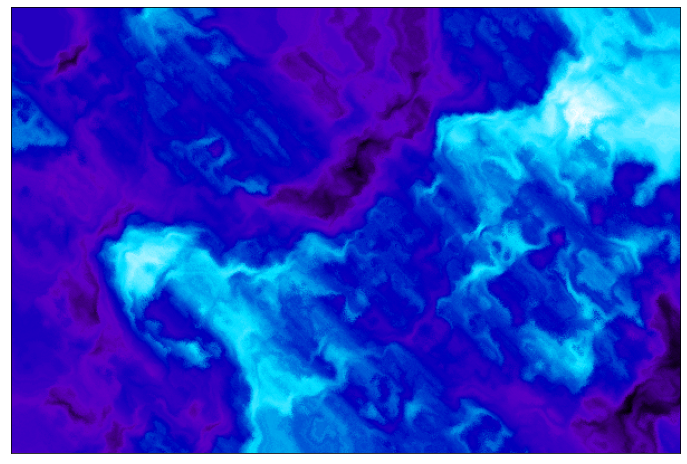

In [59]:
# Map offsetted_noise to colorspace
index_noise = (offsetted_noise * colorspace).astype(np.uint16)
index_noise = np.clip(index_noise, 0, colorspace - 1)

# Map colorspace noise to color image
colored_noise = colormap[index_noise]

# Show the image
plt.imshow(colored_noise)
plt.xticks([]);
plt.yticks([]);

I do want to control the gradient a bit more. Luckily, the same video also has a cool bias function that I can use, demoed below

In [60]:
@interact
def demo_bias_func(bias=(0, 0.99, 0.01)):
    x = np.linspace(0, 1, 200)
    k = (1 - bias)**3
    y = (x*k)/(x*k - x + 1)
    plt.plot(x, y)
    plt.title('Bias Function');

interactive(children=(FloatSlider(value=0.49, description='bias', max=0.99, step=0.01), Output()), _dom_classe…

So, same image, just using this bias function

In [61]:
def bias_func(bias, x):
    k = (1 - bias)**3
    return (x*k)/(x*k - x + 1)

@interact
def determine_bias(bias=(0, 0.99, 0.01)):
    # Map offsetted_noise to biased_noise
    biased_noise = bias_func(bias, offsetted_noise)
    
    # Map offsetted_noise to colorspace
    index_noise = (biased_noise * colorspace).astype(np.uint16)
    index_noise = np.clip(index_noise, 0, colorspace - 1)

    # Map colorspace noise to color image
    colored_noise = colormap[index_noise]

    # Show the image
    plt.imshow(colored_noise)
    plt.xticks([]);
    plt.yticks([]);

interactive(children=(FloatSlider(value=0.49, description='bias', max=0.99, step=0.01), Output()), _dom_classe…

Alright, it's ready for an iphone wallpaper. Let's do it all again!

In [62]:
# Image dimensions
height = 2700
width = 1200

# Generate a new white noise buffer
white_noise = rng.random((height, width))

def sample(r):
    """
    Sample points within the buffer.
    Then rescale while cubically 
    interpolating between points
    This can be done using scikit-image's
    rescale function. We set the order to
    3 to indicate cubic interpolation
    """
    ips = np.arange(0, height, r)
    jps = np.arange(0, width, r)
    j,i = np.meshgrid(jps,ips)
    return skt.rescale(white_noise[i,j], r, order=3)

# Scales are all common factors of the image dimensions
scales = [ 300, 100, 50, 20, 10, 5, 1 ]

# Get sampled images and factors
sampled_images = np.array([ sample(scale) for scale in scales ])
factors = np.array([ [[0.5**i]] for i in range(len(scales)) ])

# Noise is a normalized weighted sum of these samples
fractal_noise = (factors*sampled_images).sum(axis=0)
fractal_noise /= factors.sum(axis=0)

# Generate offset noise
offset = 200
offset_noise = ( fractal_noise * offset * 2 - offset ).astype(np.int16)

# Offset the noise buffer using te offsets generated
j_index, i_index = np.meshgrid(np.arange(width), np.arange(height))
i_offset = np.clip(offset_noise + i_index, 0, height - 1)
j_offset = np.clip(offset_noise + j_index, 0, width - 1)

# Update offset_noise
offsetted_noise = fractal_noise[i_offset, j_offset]
        
# Normalize
offsetted_min = np.min(offsetted_noise)
offsetted_max = np.max(offsetted_noise)
offsetted_noise = (offsetted_noise - offsetted_min) / (offsetted_max - offsetted_min)

# Create biased noise
biased_noise = bias_func(0.3, offsetted_noise)

# Colormap
index_noise = (biased_noise * colorspace).astype(np.uint16)
index_noise = np.clip(index_noise, 0, colorspace - 1)
colored_noise = colormap[index_noise]

# Save image
im = Image.fromarray(colored_noise)
im.save('data/wallpaper.png')